In [17]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('Dataset/cancer.csv')

In [18]:
# checking missing value
missing_values= df.isna().sum()
print(missing_values)

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [19]:
# Check for duplicated rows
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows values found! Removing duplicates...")
    
else:
    print("No duplicate rows values found.")

No duplicate rows values found.


In [13]:
# Check for duplicate values in the 'id' column
duplicate_ids = df.duplicated(subset=['id'])

# Check if there are any duplicate 'id' values
if duplicate_ids.any():
    print("Duplicate 'id' values found!")
else:
    print("No duplicate 'id' values found.")

No duplicate 'id' values found.


Firstly we need to check the data balance of the label class(diagnosis) and to do so we can count print the percentage of each class(M and B)

In [14]:
# Apply Label Encoding to the diagnosis column
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

In [15]:
import matplotlib.pyplot as plt

#calculate the frequancy for each diagnosis
diagnosis_frequency = df['diagnosis'].value_counts(normalize=True)*100

print("The percentage of each diagnosis:\n" + diagnosis_frequency.to_string())

The percentage of each diagnosis:
0    62.741652
1    37.258348


from the privious code we can see clearly that the data balance not have a closely equl persentage so we aim to a 60% M and 40% B as it's the closest to equality and maintane as much as possible from the data.
To done this we identified which class is takiing the larger percentage(df_majority) and which is less(df_minority) then using proportional sampling to calculate number of the class M class which down sampled to rech the disaierd distribution. Lastly join the data and update our dataset.

In [16]:
from sklearn.utils import resample

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df[df['diagnosis'] == 'B']
df_minority = df[df['diagnosis'] == 'M']

print("Number of samples in majority class:", len(df_majority))
print("Number of samples in minority class:", len(df_minority))

# Determine the number of instances to keep for the majority class
num_minority_samples = len(df_minority)
num_majority_samples_to_keep = int(num_minority_samples / 0.6 * 0.4)  # Keep 40% of the minority class

# Randomly undersample the majority class
df_majority_downsampled = df_majority.sample(n=num_majority_samples_to_keep, random_state=42)

print("Number of samples in undersampled majority class:", len(df_majority_downsampled))

# Combine majority class with minority class along rows (axis 0)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Reset index to avoid duplicate indices in concatenated DataFrame
df_balanced.reset_index(drop=True, inplace=True)

print("Number of samples in balanced dataset:", len(df_balanced))

df = df_balanced
# Now df_balanced contains a 60%-40% representation of both classes with undersampling

#calculate the frequancy for each diagnosis
diagnosis_frequency = df['diagnosis'].value_counts(normalize=True)*100

#to ensure that out work was correct we reprint the percentage
print("The percentage of each diagnosis after balaansing:\n" + diagnosis_frequency.to_string())

Number of samples in majority class: 0
Number of samples in minority class: 0
Number of samples in undersampled majority class: 0
Number of samples in balanced dataset: 0
The percentage of each diagnosis after balaansing:
Series([], )


In [8]:
# Discretization

# Create DataFrame
#df = pd.DataFrame(df)

# Define number of bins
num_bins = 3

# Iterate through each column
for col in df_balanced.columns:
    # Exclude 'diagnosis' and 'id' columns
    if col not in ['diagnosis', 'id']:
        # Perform discretization using the cut function
        df_balanced[f'discretized_{col}'] = pd.cut(df_balanced[col], bins=num_bins, labels=False, duplicates='drop')



<class 'ValueError'>: Cannot cut empty array

In [26]:
# outliers removing

# Iterate through each column
for col in df_balanced.columns:
    if col != 'diagnosis':  # Exclude 'diagnosis' column
        if np.issubdtype(df_balanced[col].dtype, np.number):  # Check if column is numeric
            # Define function to remove outliers based on mean for each column
            def remove_outliers_based_on_mean(column):
                mean = np.nanmean(column)  # Use np.nanmean() to handle NaN values
                std_dev = np.nanstd(column)
                lower_bound = mean - (2.5 * std_dev)
                upper_bound = mean + (2.5 * std_dev)
                filtered_column = column[(column >= lower_bound) & (column <= upper_bound)]
                return filtered_column

            # Apply the function to remove outliers from the column
            df_balanced[col] = remove_outliers_based_on_mean(df_balanced[col])

# Drop rows with any NaN values after removing outliers
df_balanced.dropna(inplace=True)

num_rows = df_balanced.shape[0]
print("Number of rows in the DataFrame after removing outliers:", num_rows)

Number of rows in the DataFrame after removing outliers: 246


In [39]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'diagnosis' column
label_encoder = LabelEncoder()
df_balanced['diagnosis_encoded'] = label_encoder.fit_transform(df_balanced['diagnosis'])

# Select features and target variable
X = df_balanced.drop(columns=['id', 'diagnosis', 'diagnosis_encoded'])  # Features
y = df_balanced['diagnosis_encoded']  # Encoded target variable

# Calculate the correlation coefficients between features and target variable
correlation_values = np.abs(X.corrwith(y))

# Sort the correlation values in descending order
correlation_values.sort_values(ascending=False, inplace=True)

# Select the top k features based on correlation
k = 10  # Choose the desired number of features
selected_feature_names = correlation_values.head(k).index.tolist()
df_selected = df_balanced[['diagnosis', 'id'] + selected_feature_names]
print("Selected Features based on Correlation:")
print(selected_feature_names)


Selected Features based on Correlation:
['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'area_worst', 'concavity_mean', 'perimeter_mean', 'discretized_perimeter_worst', 'discretized_radius_worst', 'concavity_worst']


In [40]:
#normalized data
from sklearn.preprocessing import StandardScaler
coulmns_to_normalize=selected_feature_names
data_to_normalize=df_selected[coulmns_to_normalize]

In [41]:
zscore_scaler=StandardScaler()
normalized_data_zscore=zscore_scaler.fit_transform(data_to_normalize)

In [38]:
df_selected[coulmns_to_normalize]=normalized_data_zscore

<ipython-input-38-02c0985be1f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[coulmns_to_normalize]=normalized_data_zscore


In [43]:
print("Z-score normalized data:")
print(df_selected)


Z-score normalized data:
             id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
395    903811.0          0       14.060         17.18       -0.371924   
110    864033.0          0        9.777         16.99       -1.600443   
481     91227.0          0       13.900         19.24       -0.417909   
493    914101.0          0       12.460         12.83       -0.864234   
136    868223.0          0       11.710         16.67       -1.049526   
..          ...        ...          ...           ...             ...   
536  91979701.0          1       14.270         22.55       -0.190689   
563    926125.0          1       20.920         25.09        2.028760   
564    926424.0          1       21.560         22.39        1.983677   
565    926682.0          1       20.130         28.25        1.496777   
566    926954.0          1       16.600         28.08        0.464370   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
395      609.1          0.080

In [44]:
#save the modified dataframe to new csv file 
df_selected.to_csv('cancer_preprossing.csv',index=False)

## The reason for using Encodeing
We encode the classified column to convert categorical data into a numerical format that can be easily used for analysis or machine learning algorithms and to be ensure that the classification task can be performed accurately and efficiently on the dataset.

## The reason for cleaning data set
Cleaning involves handling missing values, removing duplicates, correcting errors, and dealing with outliers. 
By cleaning the dataset, we aim to improve data quality, accuracy, and the robustness of any insights or predictions derived from it

## The reason for using Discretization
Discretization simplifies the process of representing data, making it easier to analyze, interpret, and make decisions, and can be useful in some machine learning algorithms.

## The reason for using normalization 

Normalization is important because it makes our data easier for modeling and evaluation. By scaling all our features to a specific range, like between 0 and 1, normalization ensures that our numbers are in a consistent format. This consistency helps our models understand and learn from the data more effectively. It also makes it simpler to compare the importance of different features in our model. Overall, normalization makes our data more manageable and helps our models perform better

## The reason for using feature selection 
we used the wrapper method which offers a comprehensive and adaptable approach to feature selection, making it well-suited for our dataset's complexities and our modeling objectives. Its ability to optimize performance, handle complex relationships, and iteratively refine feature subsets makes it a valuable choice for identifying the most relevant features for our predictive modeling tasks.

# Summary of the data set:

In this section we are going to display a quick summary of the data including sample of row data, some graphs and tables and statistics summaries.
First we have to import the data, so we can work with it and display its content correctly.

In [45]:
dataCancer = df

### Sample of data:

First we going to display the first 5 row as a sample of the preprocessed data using the following code:

In [46]:
from IPython.display import display, HTML  # Import the HTML class so we can display the table

#print sample of 1st 5  
print('The first 5 rows of the raw data:')
data_sample = dataCancer.head(5)
# Generate HTML code from the sample
sample_table = data_sample.to_html(index=False)
# Display the HTML table in the notebook
display(HTML(sample_table))

The first 5 rows of the raw data:


id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,discretized_radius_mean,discretized_texture_mean,discretized_perimeter_mean,discretized_area_mean,discretized_smoothness_mean,discretized_compactness_mean,discretized_concavity_mean,discretized_concave points_mean,discretized_symmetry_mean,discretized_fractal_dimension_mean,discretized_radius_se,discretized_texture_se,discretized_perimeter_se,discretized_area_se,discretized_smoothness_se,discretized_compactness_se,discretized_concavity_se,discretized_concave points_se,discretized_symmetry_se,discretized_fractal_dimension_se,discretized_radius_worst,discretized_texture_worst,discretized_perimeter_worst,discretized_area_worst,discretized_smoothness_worst,discretized_compactness_worst,discretized_concavity_worst,discretized_concave points_worst,discretized_symmetry_worst,discretized_fractal_dimension_worst
903811.0,0,14.060,17.18,-0.371924,609.1,0.08045,0.05361,-1.035652,-0.678684,0.1641,0.05764,0.1504,1.6850,1.237,12.67,0.005371,0.01273,0.011320,0.009155,0.01719,0.001444,-0.583946,25.34,-0.623401,-0.624444,0.10660,0.12310,0.08460,-0.852590,0.2523,0.06609,1,1,1,0,0,0,0,-0.937471,0,0,0,1,0,0,0,0,0,0,0,0,-1.030865,1,-1.057829,0,0,0,0,0,0,0
864033.0,0,9.777,16.99,-1.600443,290.2,0.10370,0.08404,-0.791403,-1.098899,0.1584,0.07065,0.4030,1.4240,2.747,22.87,0.013850,0.02932,0.027220,0.010230,0.03281,0.004638,-1.447560,21.47,-1.431045,-1.247015,0.14670,0.17650,0.13000,-1.283153,0.2533,0.08468,0,1,0,0,1,0,0,-0.937471,0,2,0,1,0,0,2,1,0,1,2,1,-1.030865,0,-1.057829,0,1,0,0,0,0,1
91227.0,0,13.900,19.24,-0.417909,602.9,0.07991,0.05326,-0.989255,-1.015598,0.1579,0.05594,0.3316,0.9264,2.056,28.41,0.003704,0.01082,0.015300,0.006275,0.01062,0.002217,-0.251444,26.42,-0.362892,-0.338159,0.10640,0.14150,0.16730,-0.812659,0.2356,0.07603,1,1,1,0,0,0,0,-0.937471,0,0,0,0,0,0,0,0,0,0,0,0,0.319759,1,0.315408,0,0,0,0,0,0,0
914101.0,0,12.460,12.83,-0.864234,477.3,0.07372,0.04043,-1.325810,-1.278339,0.1613,0.06013,0.3276,1.4860,2.108,24.60,0.010390,0.01003,0.006416,0.007895,0.02869,0.004821,-0.970006,16.36,-1.053666,-0.919552,0.09439,0.06477,0.01674,-1.726581,0.2280,0.07028,0,0,0,0,0,0,0,-0.937471,0,1,0,1,0,0,2,0,0,0,1,1,-1.030865,0,-1.057829,0,0,0,0,0,0,0
868223.0,0,11.710,16.67,-1.049526,423.6,0.10510,0.06095,-0.901042,-0.864400,0.1339,0.05945,0.4489,2.5080,3.258,34.37,0.006578,0.01380,0.026620,0.013070,0.01359,0.003707,-0.938764,25.48,-0.958342,-0.894649,0.12710,0.10280,0.10460,-1.010146,0.1712,0.07343,0,1,0,0,1,0,0,-0.937471,0,1,0,2,0,0,1,0,0,1,0,0,-1.030865,1,-1.057829,0,1,0,0,0,0,0


## Data Visualization

Displaying the data in a graphic format can help to analyze the data and reporting it. We used several charts as following:

We use the pie chart to show the percentage of different diagnosis in our data which turn out to be 62.7% benign and 37.3% malignant.

In [ ]:
# graphs and tables show variable distribution , missing values
import matplotlib.pyplot as plt

#calculate the frequancy for each diagnosis
diagnosis_frequency = dataCancer['diagnosis'].value_counts(normalize=True)*100

#plot a ppie chart
diagnosis_frequency.plot.pie(autopct='%1.1f%%',figsize=(5,5),startangle=90)

#display the plot with appropriate apperance by changing the values of the attribute
plt.title('Diagnosis frequency')
plt.ylabel('')
plt.show()

Also, we use the plot box to show variable distribution for each attribute and comparing the values across different diagnosis.

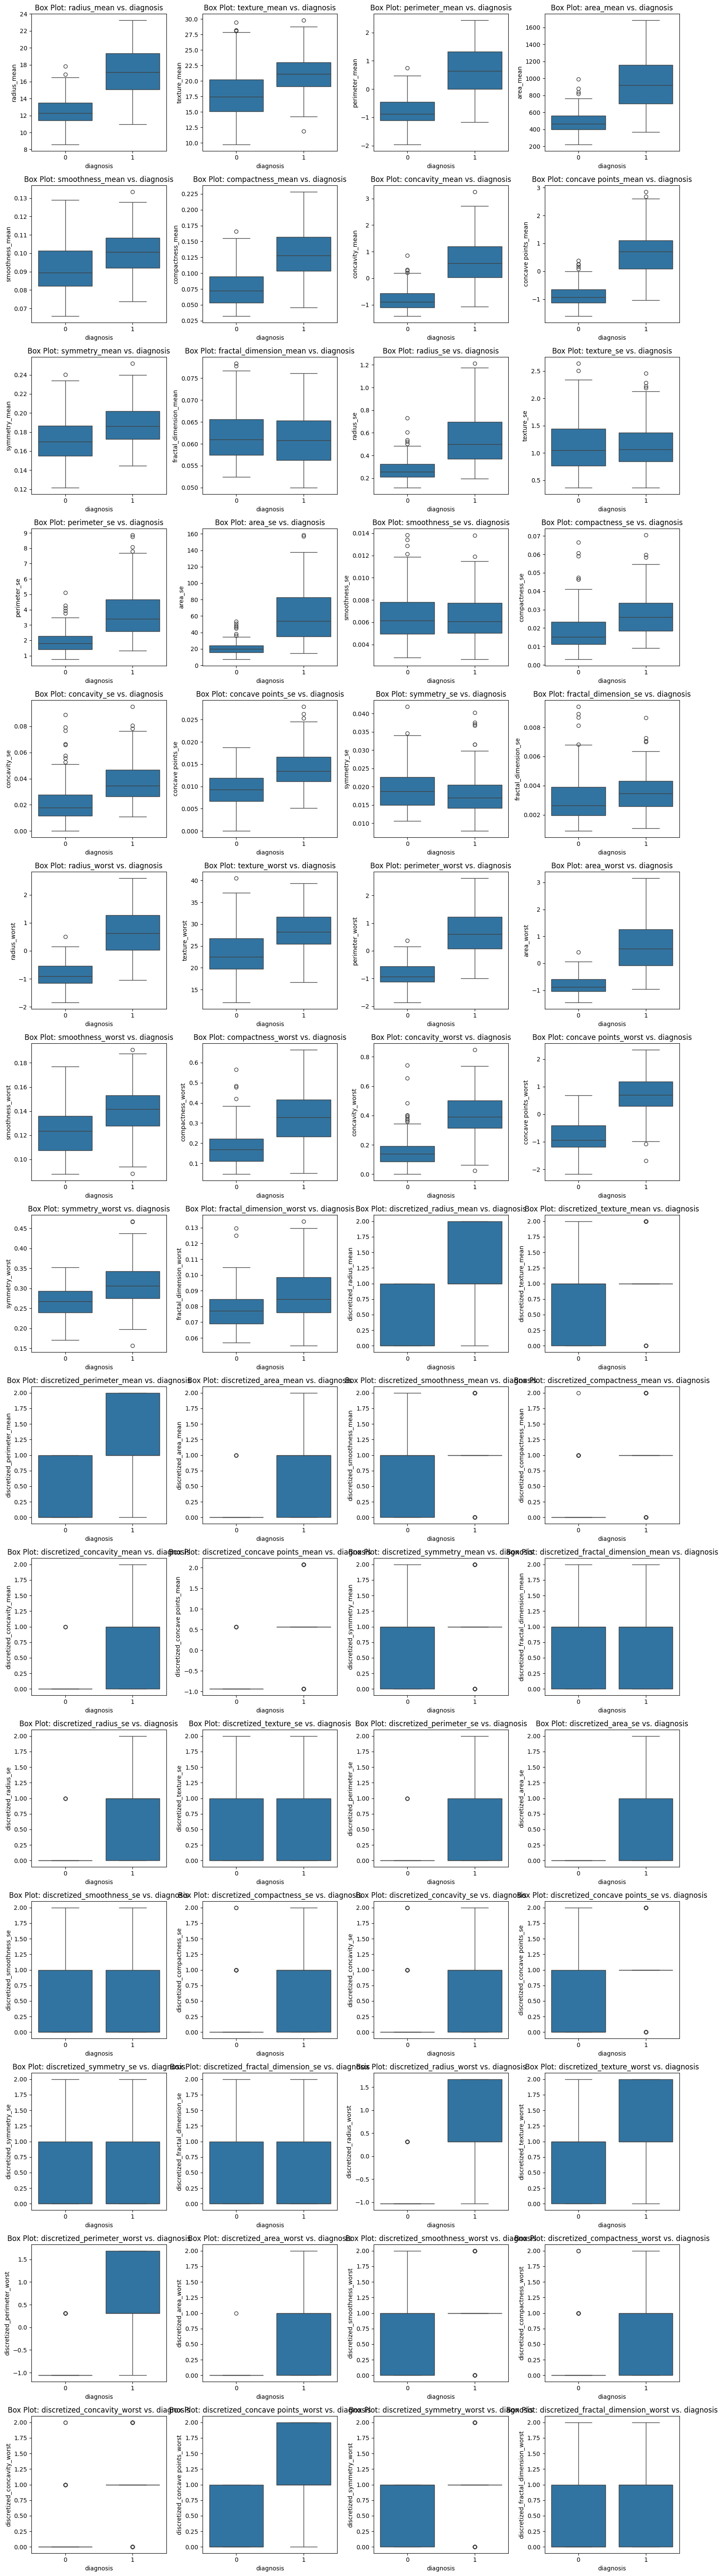

In [48]:
#this is to solve the problem of "ModuleNotFoundError: No module named ‘seabor’"
%pip install seaborn 
import seaborn as sns


target_column = 'diagnosis'

# choosing the numiric data only
feature_columns = dataCancer.columns[(dataCancer.columns != target_column) & (dataCancer.columns != 'id')]


# Determine the number of rows and columns for the subplot layout
num_features = len(feature_columns)
num_rows = (num_features - 1) // 4 + 1
num_cols = min(4, num_features)

# Create box plots for each feature grouped by 'diagnosis'
plt.figure(figsize=(16, 4 * num_rows))

for i, feature in enumerate(feature_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=target_column, y=feature, data=dataCancer)
    plt.title(f'Box Plot: {feature} vs. {target_column}')
    plt.xlabel(target_column)
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Majority of our data is a numeric data and one of the best ways to visualize it is using the matrix of scatter plots(pair plot) in order to have a clear vision of the relationship between the data.

In [ ]:
#exclude the id attribute
selected_feature = dataCancer.iloc[:, 1:]

# Create a matrix of scatter plots
sns.pairplot(selected_feature, hue='diagnosis', palette = 'Set2')


plt.suptitle('Pair Plot of Breast Cancer Dataset', y=1.02)
plt.show()
#note: the code might not be excuted in github duo to the lanrge size of the resulted graph that prevent the file to be loaded
#the graph was excuted by VS code because jupyter can't handle the lanrge size of the graph so pleas try it in other tools that jupyter with lange memory space

## Summary Statistics

It's important to take a look at the statistic summary to capture the different characteristics of our data set, such as the central tendency measurement and the variance. The table below shows these measurements that have been calculated by the python code above it.

In [ ]:
import statistics as st

summary_data = []

for columnName in feature_columns:
    columnData = dataCancer[columnName]
    midrange = (max(columnData) + min(columnData)) / 2
    summary_data.append({
        'Feature': columnName,
        'Mean': st.mean(columnData),
        'Median': st.median(columnData),
        'Mode': st.mode(columnData),
        'Midrange': midrange,
        'Variance': st.variance(columnData)
    })

# Create the DataFrame after the loop
statistical_summaries = pd.DataFrame(summary_data)

# Generate HTML code from the DataFrame
statistical_summaries_table = statistical_summaries.to_html(index=False)
# Display the HTML table in the notebook
display(HTML(statistical_summaries_table))